# Particle Swarm Optimization (PSO)
Particle Swarm Optimization (PSO) is one of the heuristic optimization methods that use swarming rules of the birds/insects that we see in nature. The main idea is to follow the leading member/leading group of particles of the swarm who are close to the goal (most probably the food) of the team.

The very first thing to do is to import neccesarry modules to our python environment. The pygame moodule is used for visualization of what is happening through the iterations. It can be taken to "off" if not necessary.

In [1]:
# Import Modules
import numpy as np
import pygame
import random
import math
from matplotlib import pyplot as plt

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


# Swarm Class

The swarm class given below consists of sub-routines what is needed for PSO.

The init function is the main body of our class where we define the basic features of the swarming particle objects. We input the function as well as the lower and upper bounds that are obligatory. Some ("egg" and "griewank") of the universal test functions defined in the "Universal Test Functions" section given after, are predefined inside the init function with their lower and upper boundaries, however, in real cases, these arguments should be input by the user. The pygame screen where the user can visualize what is happening inside the swarm is in the "off" mode by default but can be made "on" by making the "display" argument "True". The migration is inherently on if nothing is done but can be closed by changing the "migrationexists" argument to "False". The migration probability is set to 0.15 by default and can be changed if necessary. The default number of particles inside the swarm is kept at 50 but can be changed, either.

The functions "coefficients", "evaluate_fitness", "distance", "migration" and "optimize" are the functions where the main PSO algorithm is run that the user does not need to consider about. The values given in the coefficients were obtained from MoGenA (Multi Objective Genetic Algorithm) and should be kept unchanged for the best performance, that is why any user calling swarm class will not see the values in normal usage. There will be migration with a probability of 15%, where the worst 20% of the swarm is going to be changed with new particles. Some of these new particles will be placed to the domain randomly while the rest will be placed according to some predefined algorithm that is promoting the best particles. This migration algorithm deveoped here increases the rate of finding the global optimum value by decreasing the chance of being stuck at a alocal minima.

The itarations are done by calling "update" function where the default iteration number is given as 50.

In [2]:
# Swarm Class
class swarm():
    def __init__(self, func, lowerbounds=[], upperbounds=[], number_of_particles=50, display=False,
                 migrationexists=True, pmig=0.15):
        self.lowerbounds  = lowerbounds
        self.upperbounds  = upperbounds
        self.nop          = number_of_particles
        self.display      = display
        self.func         = func
        self._vel_max     = 20.0
        self._vel_min     = -20.0
        self.member       = {}
        self.pmig         = pmig
        self.iteration_no = 0
        self.migrationexists = migrationexists
        self.__coefficients()
        self.best_value_iteration = 0
        self.best_value           = list([10**8])
        
        if self.func.__name__   == 'egg':
            self.lowerbounds  = [-512,-512]
            self.upperbounds  = [512,512]
        elif self.func.__name__ == 'griewank':
            self.lowerbounds  = [-600,-600]
            self.upperbounds  = [600,600]
        
        if self.display:
            self.screen       = pygame.display.set_mode((self.upperbounds[0]-self.lowerbounds[0],
                                                         self.upperbounds[1]-self.lowerbounds[1]))
            pygame.display.set_caption("Particle Swarm Optimization")
            self.screen.fill(self.WHITE)
                    
        for ii in range(self.nop):
            self.member[str(ii)] = {'center':(0,0)}
            self.member[str(ii)]['best_value'] = 10**8
            
            self.member[str(ii)]['position']      = {str(jj): np.random.random()*\
                                                    (self.upperbounds[jj]-self.lowerbounds[jj])+\
                                                     self.lowerbounds[jj] for jj in range(len(self.lowerbounds))}
            self.member[str(ii)]['best_position'] = {str(jj): np.random.random()*\
                                                    (self.upperbounds[jj]-self.lowerbounds[jj])+\
                                                     self.lowerbounds[jj] for jj in range(len(self.lowerbounds))}
            self.member[str(ii)]['velocity']      = {str(jj): np.random.random()\
                                                     for jj in range(len(self.lowerbounds))}
            self.member[str(ii)]['center'] = (int(np.round(self.member[str(ii)]['position']['0'])),
                                              int(np.round(self.member[str(ii)]['position']['1'])))
        
        self._evaluate_fitness()
        self._distance()
    
    def __coefficients(self):
        self.BLUE  = (0,0,255)
        self.WHITE = (255,255,255)
        self.BLACK = (0,0,0)
        self.RED   = (255,0,0)
        self.__coefficients         = {}
        self.__coefficients['eta0'] = 1.0
        self.__coefficients['wght'] = 0.0196
        self.__coefficients['eta1'] = 3.9804
        self.__coefficients['eta2'] = 0.2157
        self.__coefficients['eta3'] = 3.2353
        self.__coefficients['eta4'] = 0.5098
        
    def _evaluate_fitness(self):
        '''evaluates the fitness function for the members of the swarm'''
        self.fitness_values = {'_'           :{},
                               'sorted'      :{},
                               'best'        :{},
                               'best_sorted' :{}}
        for ii in range(self.nop):
            self.member[str(ii)]['fitness_value'] = self.func([self.member[str(ii)]\
                                                    ['position'][str(jj)] for jj in\
                                                    range(len(self.lowerbounds))])
            
            if self.member[str(ii)]['fitness_value']<self.member[str(ii)]['best_value']:
                self.member[str(ii)]['best_value'] = self.member[str(ii)]['fitness_value']
                for jj in range(len(self.lowerbounds)):
                    self.member[str(ii)]['best_position'][str(jj)] = self.member[str(ii)]['position'][str(jj)]
        
            self.fitness_values['_'][str(ii)]    = self.member[str(ii)]['fitness_value']
            self.fitness_values['best'][str(ii)] = self.member[str(ii)]['best_value']

        self._sorted_fitness_value    = sorted(self.fitness_values['_'].items(), key = lambda kv:(kv[1], kv[0]))
        self.fitness_values['sorted'] = {str(self._sorted_fitness_value[ii][0]):self._sorted_fitness_value[ii][1]\
                                         for ii in range(self.nop)}
        
        self._sorted_best_value       = sorted(self.fitness_values['best'].items(), key = lambda kv:(kv[1], kv[0]))
        self.fitness_values['best_sorted'] = {str(self._sorted_best_value[ii][0]):self._sorted_best_value[ii][1]\
                                              for ii in range(self.nop)}
        
        
        self.best_position      = {list(self.fitness_values['sorted'].keys())[ii]:\
                                  self.member[list(self.fitness_values['sorted'].keys())[ii]]['position']\
                                  for ii in range(self.nop)}
        
        self.best_position_ever = {list(self.fitness_values['best_sorted'].keys())[ii]:\
                                  self.member[list(self.fitness_values['best_sorted'].keys())[ii]]['best_position']\
                                  for ii in range(self.nop)}
            
    def _distance(self):
        '''calculates the distances between the members of the swarm'''
        for ii in range(self.nop):
            self.member[str(ii)]['distance'] = {str(jj): {str(kk): self.member[str(ii)]['position'][str(kk)]-\
                                                         self.member[str(jj)]['position'][str(kk)]\
                                                         for kk in range(len(self.lowerbounds))}\
                                                         for jj in range(self.nop)}
            
            self.member[str(ii)]['distance_sorted'] = {str(jj):sorted(np.abs(self.member[str(ii)]['distance']\
                                                      [str(kk)][str(jj)]) for kk in range(self.nop)) for jj in\
                                                       range(len(self.lowerbounds))}
            
            self.member[str(ii)]['abs_distance'] = {str(jj): np.sqrt(math.fsum(self.member[str(ii)]['distance']\
                                                             [str(jj)][str(kk)]**2 for kk in\
                                                             range(len(self.lowerbounds)))) for jj in\
                                                             range(self.nop)}
            
            self.member[str(ii)]['abs_distance_sorted'] = [sorted(self.member[str(ii)]['abs_distance'].items(),\
                                                          key = lambda kv:(kv[1], kv[0]))[jj][1] for jj in\
                                                          range(self.nop)]
            
            self.member[str(ii)]['closest_neighbours'] = [sorted(self.member[str(ii)]['abs_distance'].items(),\
                                                          key = lambda kv:(kv[1], kv[0]))[jj][0] for jj in\
                                                          range(self.nop)]
            
            self.member[str(ii)]['closest_neighbours_fitness_values'] = {self.member[str(ii)]['closest_neighbours'][jj]:\
                                                                         self.member[self.member[str(ii)]['closest_neighbours'][jj]]['fitness_value']\
                                                                         for jj in range(self.nop)}
            
            self.member[str(ii)]['closest_neigbours_best'] = sorted(list(self.member[str(ii)]\
                                                                 ['closest_neighbours_fitness_values'].items())[1:5],
                                                                 key=lambda kv:(kv[1],kv[0]))[0][0]
            
            '''distance from the closest particle which has the best fitness value'''
            self.member[str(ii)]['distance_from_closest_best'] = self.member[str(ii)]['distance']\
                                                                [self.member[str(ii)]['closest_neigbours_best']]
            
    def _migration(self):
        '''migration calculations are generated if there exists migration'''
        if np.random.random() < self.pmig:
            self.migration = True
            self.nowp  = int(np.round(0.20*self.nop))        # number of worst particles
            self.nobp  = int(np.round(0.20*self.nop))        # number of best particles
            self.w2bp  = self._sorted_fitness_value[::-1]    # sorted worst to best particles and fitnesses
            self.b2wp  = self._sorted_fitness_value          # sorted best to worst particles and fitnesses
            self.bafv  = np.average([self._sorted_fitness_value[ii][1]\
                                    for ii in range(self.nobp)]) # best average fitness value
            self.bapos = {str(jj): np.average([self.member[self._sorted_fitness_value[ii][0]]\
                                              ['position'][str(jj)] for ii in range(self.nobp)])\
                                              for jj in range(len(self.lowerbounds))} # best average positions
            self.worst_particle_indices = {}
            counter = 0
            for ii in range(4):
                # worst particle indices are seperated 4 sub-groups from worst to best
                self.worst_particle_indices[ii] = [self.w2bp[counter+ii][0] for\
                                                   ii in range(int(np.round(0.25*self.nowp)))]
                counter = counter + int(np.round(0.25*self.nowp))
                
            for ind in (self.worst_particle_indices[0]):
                self.member[str(ind)]['position'] = {str(jj): np.random.random()*\
                                                              (self.upperbounds[jj]-self.lowerbounds[jj])+\
                                                              self.lowerbounds[jj] for jj in\
                                                              range(len(self.lowerbounds))}
                self.member[str(ind)]['velocity'] = {str(jj): np.random.random()\
                                                              for jj in range(len(self.lowerbounds))}
                
            for ind in (self.worst_particle_indices[1]):
                self.member[str(ind)]['position'] = {str(jj): 0.10*np.random.random()*\
                                                              (self.upperbounds[jj]-self.lowerbounds[jj])+\
                                                              np.random.permutation([-1,1])[0]*self.bapos[str(jj)]\
                                                              for jj in range(len(self.lowerbounds))}
                self.member[str(ind)]['velocity'] = {str(jj): np.random.random()\
                                                              for jj in range(len(self.lowerbounds))}
                
            for ind in (self.worst_particle_indices[2]):
                self.member[str(ind)]['position'] = {str(jj): 0.05*np.random.random()*\
                                                              (self.upperbounds[jj]-self.lowerbounds[jj])+\
                                                              list(self.best_position.values())[0][str(jj)]\
                                                              for jj in range(len(self.lowerbounds))}
                self.member[str(ind)]['velocity'] = {str(jj): np.random.random()\
                                                              for jj in range(len(self.lowerbounds))}
                
            for ind in (self.worst_particle_indices[3]):
                self.member[str(ind)]['position'] = {str(jj): 0.05*np.random.random()*\
                                                              (self.upperbounds[jj]-self.lowerbounds[jj])+\
                                                              list(self.best_position_ever.values())[0][str(jj)]\
                                                              for jj in range(len(self.lowerbounds))}
                self.member[str(ind)]['velocity'] = {str(jj): np.random.random()\
                                                              for jj in range(len(self.lowerbounds))}
            
            for ii in range(4):
                for ind in (self.worst_particle_indices[ii]):
                    for jj in range(len(self.lowerbounds)):
                        if self.member[str(ind)]['position'][str(jj)] > self.upperbounds[jj]:
                            self.member[str(ind)]['position'][str(jj)] = self.upperbounds[jj]
                        elif self.member[str(ind)]['position'][str(jj)] < self.lowerbounds[jj]:
                            self.member[str(ind)]['position'][str(jj)] = self.lowerbounds[jj]
                            
        else:
            self.migration    = False
                    
    def _optimize(self):
        '''PSO algoritm'''
        for ii in range(self.nop):
            for jj in range(len(self.lowerbounds)):
                self.member[str(ii)]['velocity'][str(jj)] =  self.__coefficients['eta0'] * np.random.random()*\
                                                             ((self.__coefficients['wght'] * \
                                                             self.member[str(ii)]['velocity'][str(jj)]) + \
                                                             self.__coefficients['eta1'] * np.random.random() * \
                                                             self.member[str(ii)]['best_position'][str(jj)] - \
                                                             self.member[str(ii)]['position'][str(jj)] + \
                                                             self.__coefficients['eta2'] * np.random.random() * \
                                                             list(self.best_position.values())[0][str(jj)] - \
                                                             self.member[str(ii)]['position'][str(jj)] + \
                                                             self.__coefficients['eta3'] * np.random.random() * \
                                                             list(self.member[str(ii)]['distance_sorted'].values())[jj][1] + \
                                                             self.__coefficients['eta4'] * np.random.random() * \
                                                             self.member[str(ii)]['distance_from_closest_best']\
                                                             [str(jj)])
        
                if self.member[str(ii)]['velocity'][str(jj)] > self._vel_max:
                    self.member[str(ii)]['velocity'][str(jj)] = self._vel_max
                elif self.member[str(ii)]['velocity'][str(jj)] < self._vel_min:
                    self.member[str(ii)]['velocity'][str(jj)] = self._vel_min
                    
                self.member[str(ii)]['position'][str(jj)] = self.member[str(ii)]['position'][str(jj)] + \
                                                            self.member[str(ii)]['velocity'][str(jj)]
                
                if self.member[str(ii)]['position'][str(jj)] > self.upperbounds[jj]:
                    self.member[str(ii)]['position'][str(jj)] = self.upperbounds[jj]
                elif self.member[str(ii)]['position'][str(jj)] < self.lowerbounds[jj]:
                    self.member[str(ii)]['position'][str(jj)] = self.lowerbounds[jj]
             
    def update(self,iteration=50): 
        '''updates the position and velocity of the members of the swarm'''
        self.iteration  = iteration
        for iter_no in range(self.iteration):
            self.iteration_no = self.iteration_no + 1
            self._optimize()
            self._evaluate_fitness()
            self._distance()
            if self.migrationexists:
                self._migration()
                if self.migration:
                    self._evaluate_fitness()
                    self._distance()

            for ii in range(self.nop):
                self.member[str(ii)]['center'] = (int(np.round(self.member[str(ii)]['position']['0'])\
                                                      -self.lowerbounds[0]),
                                                  int(np.round(self.member[str(ii)]['position']['1'])\
                                                      +self.upperbounds[0]))
                if self.display:
                    pygame.draw.circle(self.screen,self.BLUE,self.member[str(ii)]['center'],2)

            if self.display:
                pygame.display.flip()     
                self.screen.fill(self.WHITE)
            
            if self.member[list(self.best_position_ever.keys())[0]]['best_value'] < self.best_value[-1]:
                self.best_value_iteration = self.iteration_no
            
            self.best_value.append(self.member[list(self.best_position_ever.keys())[0]]['best_value'])
                
            print('iteration no       : ',self.iteration_no)
            print('migration          : ',self.migration)
            print('best_particle      : ',list(self.best_position.keys())[0])
            print('best_position      : ',self.member[list(self.best_position.keys())[0]]['best_position'])
            print('best_value         : ',self.member[list(self.best_position.keys())[0]]['fitness_value'])
            print('best_particle_ever : ',list(self.best_position_ever.keys())[0])
            print('best_position_ever : ',self.member[list(self.best_position_ever.keys())[0]]['best_position'])
            print('best_value_ever    : ',self.member[list(self.best_position_ever.keys())[0]]['best_value'])
            print('best_value_obtained at iteration no: %s' % (self.best_value_iteration))
            print('--------------------------------------------------------')
            
        plt.plot(np.arange(len(self.best_value[1:])),self.best_value[1:])

# Universal Test Functions

Universal test functions are used to evaluate/compare the performance of the optimization methods. They are generally very hard functions to optimize with lots of local minima that are very close to global minima. The mostly used ones are given in the address https://www.sfu.ca/~ssurjano/optimization.html and some of them are given in the next section, below.

In [3]:
# Universal Test Functions
def egg(*args):
    x1    = args[0][0]
    x2    = args[0][1]
    term1 = -(x2+47) * math.sin(math.sqrt(math.fabs(x2+x1/2+47)))
    term2 = -x1 * math.sin(math.sqrt(math.fabs(x1-(x2+47))))
    out   = term1 + term2
    return out

def griewank(*args):
    d    = len(args[0])
    sum  = 0
    prod = 1
    for ii in range(d):
        xi   = args[0][ii]
        sum  = sum + xi**2/4000
        prod = prod * math.cos(xi/math.sqrt(ii+1))
    out = sum - prod + 1
    return out

def bukin6(*args):
    x1 = args[0][0]
    x2 = args[0][1]    
    term1 = 100 * math.sqrt((abs(x2-0.01*x1**2)))
    term2 = 0.01 * abs(x1+10)    
    out = term1 + term2
    return out

def ackley(*args):
    d    = len(args[0])
    c    = math.pi * 2
    b    = 0.20
    a    = 20
    
    sum1 = 0
    sum2 = 0
    
    for ii in range(d):
        xi   = args[0][ii]
        sum1 = sum1 + xi**2
        sum2 = sum2 + math.cos(c*xi)
    
    term1 = -a * math.exp(-b*math.sqrt(sum1/d))
    term2 = -math.exp(sum2/d)
    
    y = term1 + term2 + a + math.exp(1)
    
    return y

def drop(*args):
    x1 = args[0][0]
    x2 = args[0][1]
    frac1 = 1+math.cos(12*math.sqrt(x1**2 + x2**2))
    frac2 = 0.5*(x1**2 + x2**2) + 2
    out = -frac1/frac2
    return out

fitness_function             = {}
fitness_function['egg']      = egg
fitness_function['griewank'] = griewank
fitness_function['bukin6']   = bukin6
fitness_function['ackley']   = ackley
fitness_function['drop']     = drop

# Generate Particles

The first thing to do is to generate the swarming particles randomly inside the boundaries of the function domain. The example below is done with "egg" function predefined inside the swarm class with its lower [-512,-515] and upper [512, 512] boundaries. The number of particles is given as 100, which means we will have a swarm that has 100 particles inside. The default display mode is off but since we want to visualize what is happening, the display mode changed to "True". There will be migration in the swarm and its probability parameter is kept as default.

The "egg" function is given as follows.

The global optimum point is at (512,404.2319) with a value of -959.6407.

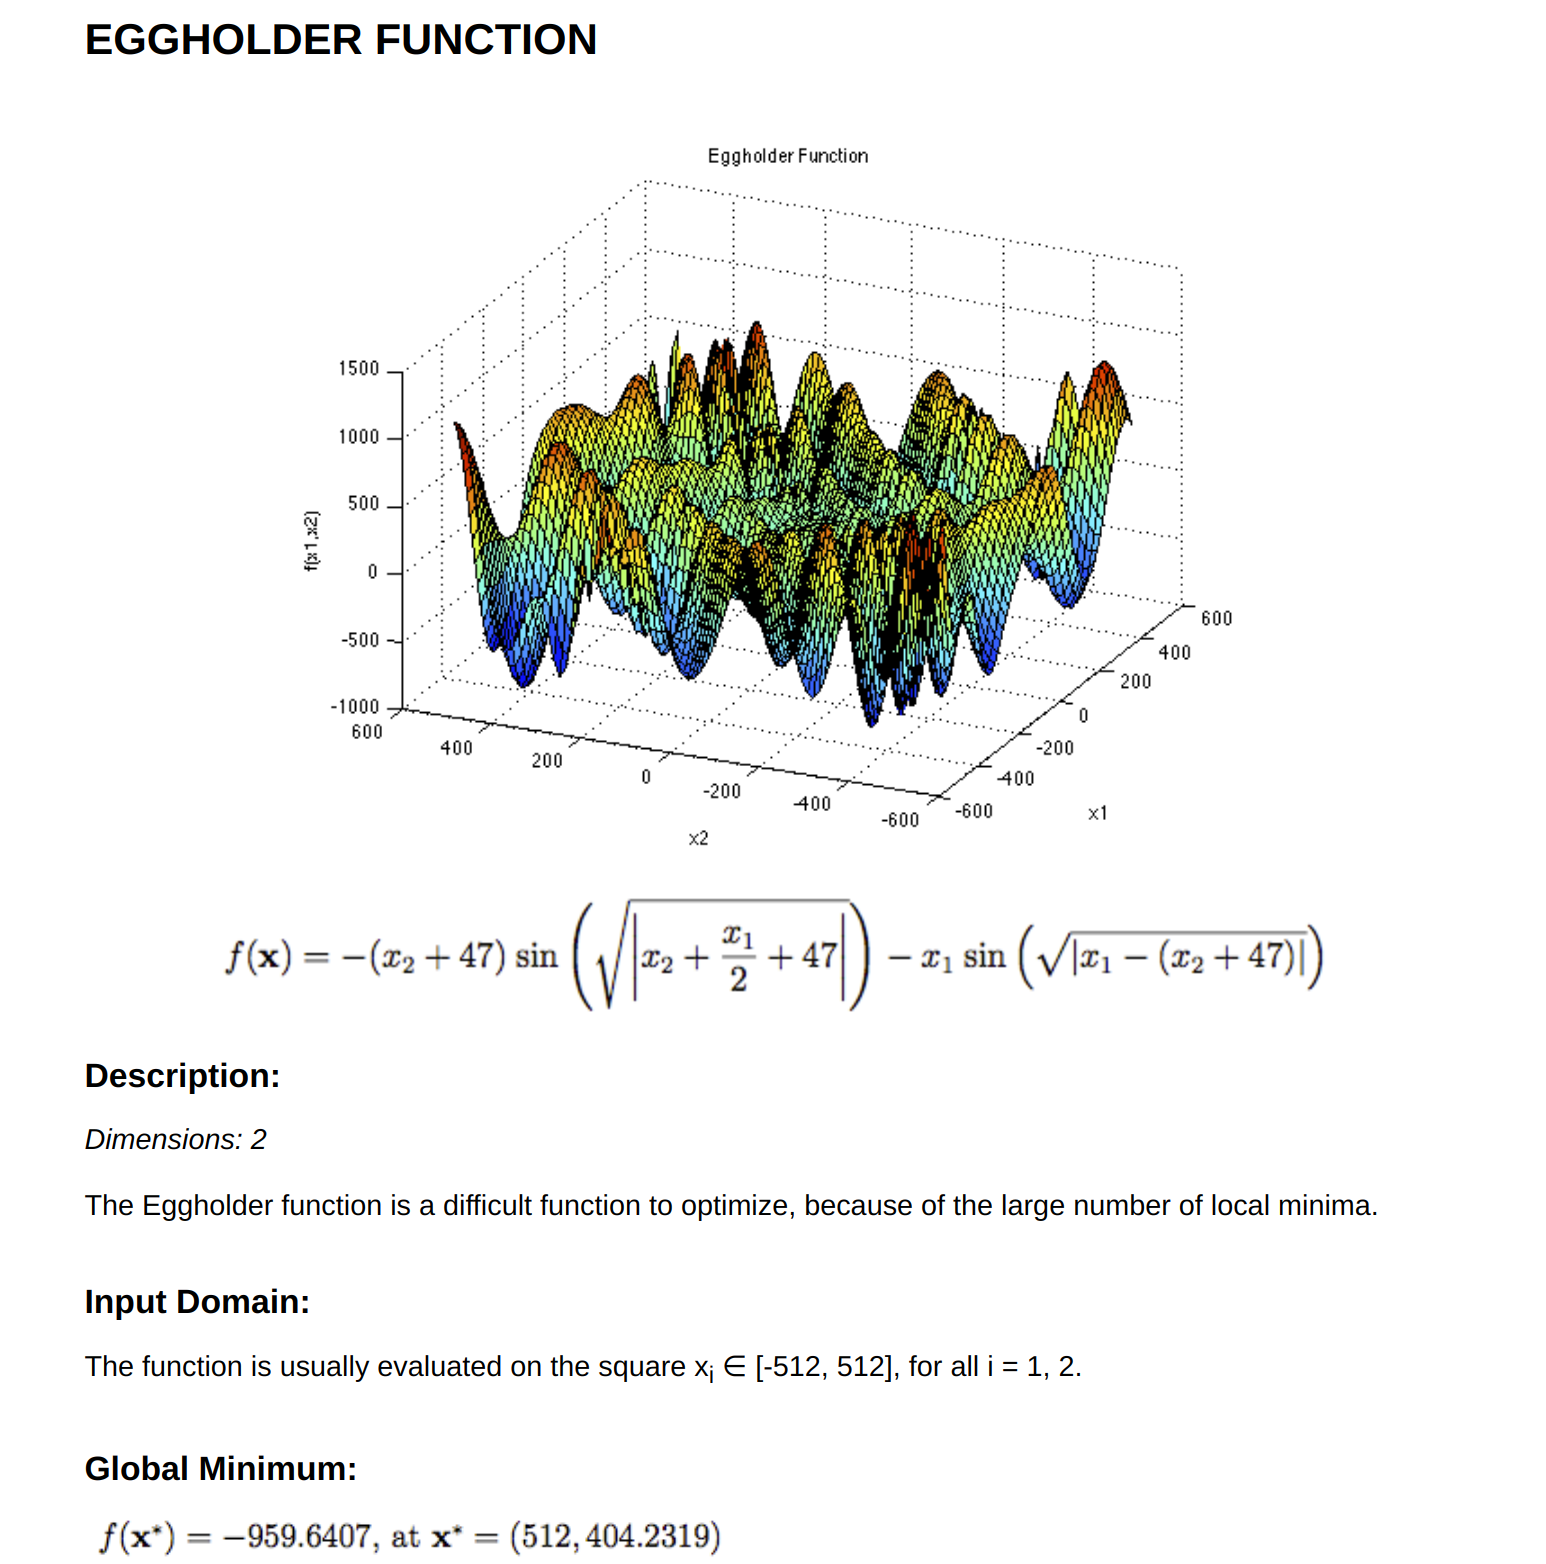

In [4]:
# Generate Particles
particles = swarm(func=fitness_function['egg'],number_of_particles=100,display=False)

iteration no       :  1
migration          :  False
best_particle      :  55
best_position      :  {'0': 428.9557213625035, '1': 447.05742470519556}
best_value         :  -911.382757564217
best_particle_ever :  55
best_position_ever :  {'0': 428.9557213625035, '1': 447.05742470519556}
best_value_ever    :  -911.382757564217
best_value_obtained at iteration no: 1
--------------------------------------------------------
iteration no       :  2
migration          :  False
best_particle      :  55
best_position      :  {'0': 428.9557213625035, '1': 447.05742470519556}
best_value         :  -896.400531430531
best_particle_ever :  55
best_position_ever :  {'0': 428.9557213625035, '1': 447.05742470519556}
best_value_ever    :  -911.382757564217
best_value_obtained at iteration no: 1
--------------------------------------------------------
iteration no       :  3
migration          :  False
best_particle      :  7
best_position      :  {'0': -385.89742475339085, '1': -408.948499795639}
best_va

iteration no       :  22
migration          :  False
best_particle      :  93
best_position      :  {'0': 512, '1': 405.0517246862257}
best_value         :  -958.8723670862023
best_particle_ever :  4
best_position_ever :  {'0': 512, '1': 404.06685154916477}
best_value_ever    :  -959.6097641491075
best_value_obtained at iteration no: 18
--------------------------------------------------------
iteration no       :  23
migration          :  False
best_particle      :  96
best_position      :  {'0': 512, '1': 401.9999923881293}
best_value         :  -929.665867448137
best_particle_ever :  4
best_position_ever :  {'0': 512, '1': 404.06685154916477}
best_value_ever    :  -959.6097641491075
best_value_obtained at iteration no: 18
--------------------------------------------------------
iteration no       :  24
migration          :  False
best_particle      :  77
best_position      :  {'0': 512.0, '1': 401.2401039990411}
best_value         :  -909.9734222739701
best_particle_ever :  4
best_po

iteration no       :  43
migration          :  False
best_particle      :  13
best_position      :  {'0': 351.1163833159949, '1': 496.15838922958307}
best_value         :  -839.5193422016183
best_particle_ever :  4
best_position_ever :  {'0': 512, '1': 404.06685154916477}
best_value_ever    :  -959.6097641491075
best_value_obtained at iteration no: 18
--------------------------------------------------------
iteration no       :  44
migration          :  True
best_particle      :  48
best_position      :  {'0': 512, '1': 399.34327598538005}
best_value         :  -900.076630066269
best_particle_ever :  4
best_position_ever :  {'0': 512, '1': 404.06685154916477}
best_value_ever    :  -959.6097641491075
best_value_obtained at iteration no: 18
--------------------------------------------------------
iteration no       :  45
migration          :  False
best_particle      :  52
best_position      :  {'0': 512, '1': 406.938326119616}
best_value         :  -947.3435096716489
best_particle_ever 

iteration no       :  64
migration          :  False
best_particle      :  62
best_position      :  {'0': 350.1680831615465, '1': 499.0804509955593}
best_value         :  -873.9314314181241
best_particle_ever :  4
best_position_ever :  {'0': 512, '1': 404.06685154916477}
best_value_ever    :  -959.6097641491075
best_value_obtained at iteration no: 18
--------------------------------------------------------
iteration no       :  65
migration          :  False
best_particle      :  77
best_position      :  {'0': 512, '1': 402.6134524251648}
best_value         :  -952.0427163056474
best_particle_ever :  4
best_position_ever :  {'0': 512, '1': 404.06685154916477}
best_value_ever    :  -959.6097641491075
best_value_obtained at iteration no: 18
--------------------------------------------------------
iteration no       :  66
migration          :  False
best_particle      :  58
best_position      :  {'0': 512, '1': 398.1422180123329}
best_value         :  -919.5521178792376
best_particle_ever

iteration no       :  85
migration          :  False
best_particle      :  71
best_position      :  {'0': 512, '1': 401.6939486976046}
best_value         :  -902.394000982212
best_particle_ever :  4
best_position_ever :  {'0': 512, '1': 404.06685154916477}
best_value_ever    :  -959.6097641491075
best_value_obtained at iteration no: 18
--------------------------------------------------------
iteration no       :  86
migration          :  False
best_particle      :  55
best_position      :  {'0': 492.0, '1': 441.98312486421423}
best_value         :  -934.2597123935204
best_particle_ever :  4
best_position_ever :  {'0': 512, '1': 404.06685154916477}
best_value_ever    :  -959.6097641491075
best_value_obtained at iteration no: 18
--------------------------------------------------------
iteration no       :  87
migration          :  False
best_particle      :  71
best_position      :  {'0': 512, '1': 401.6939486976046}
best_value         :  -916.0565785449696
best_particle_ever :  4
best_p

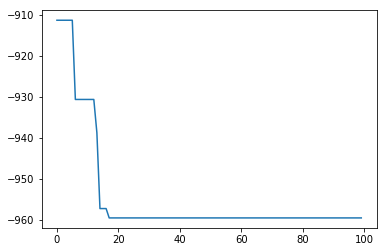

In [5]:
# Iterate Optimization
particles.update(iteration=100)

# The Result

When the results are investigated, followings are obtained as a result:

Total number of iterations is 310.

Almost the best result is obtained just in 30 iterations when the plot at the end is examined.

The best result is obtained at the iteration 101.

The following sections give extra information about the best position and values.

The best particle is the particle 55 with the position (512, 404.3717) of the value -959.6184, while the second one is the particle 22 with the position (512, 404.3928) of the value -959.6112

In [6]:
# Best Positions Ever
particles.best_position_ever

{'4': {'0': 512, '1': 404.06685154916477},
 '0': {'0': 512, '1': 403.41897472416804},
 '93': {'0': 512, '1': 405.0517246862257},
 '83': {'0': 512, '1': 405.52696266818145},
 '14': {'0': 512, '1': 405.6516212429787},
 '77': {'0': 512, '1': 402.6134524251648},
 '66': {'0': 512, '1': 402.52656336726204},
 '58': {'0': 512, '1': 402.3495274477991},
 '96': {'0': 512, '1': 401.9999923881293},
 '55': {'0': 512, '1': 401.98312486421423},
 '31': {'0': 512, '1': 401.84217327606774},
 '98': {'0': 512, '1': 406.6064570160218},
 '22': {'0': 478.5460740268192, '1': 434.32553138712785},
 '71': {'0': 512, '1': 401.6939486976046},
 '52': {'0': 512, '1': 406.938326119616},
 '48': {'0': 512, '1': 407.27222920431336},
 '27': {'0': 512.0, '1': 407.29599652657635},
 '41': {'0': 487.29910829735434, '1': 437.27751816514626},
 '34': {'0': 512, '1': 408.4607678980187},
 '79': {'0': 512, '1': 399.8652347723496},
 '95': {'0': 472.0, '1': 422.5125211141302},
 '86': {'0': 441.84844006763643, '1': 456.42545839904557}

In [7]:
# Best Values Ever
particles.fitness_values['best_sorted']

{'4': -959.6097641491075,
 '0': -958.8937581340952,
 '93': -958.8723670862023,
 '83': -957.7180880030078,
 '14': -957.3284839816108,
 '77': -956.6972586400544,
 '66': -956.3748585672203,
 '58': -955.6669276858324,
 '96': -954.0692205612262,
 '55': -953.9854373064612,
 '31': -953.2613703702488,
 '98': -953.1382868930233,
 '22': -952.9127792582286,
 '71': -952.4539415639711,
 '52': -951.1792069666101,
 '48': -948.9447822738464,
 '27': -948.775642087169,
 '41': -946.3528672296995,
 '34': -938.835973820461,
 '79': -938.6929384857299,
 '95': -936.7737962750193,
 '86': -934.1818498765037,
 '70': -933.2055132781859,
 '61': -932.8999283611587,
 '80': -925.2948057278762,
 '29': -923.4579509813984,
 '24': -922.8732638029367,
 '78': -922.765939377461,
 '45': -922.5296583998511,
 '33': -920.5158691288018,
 '53': -919.7001277544729,
 '89': -919.3927736577709,
 '25': -911.3469599445214,
 '44': -894.1849086836874,
 '75': -892.4498504977753,
 '20': -889.3877319916764,
 '59': -888.7342697785627,
 '62':

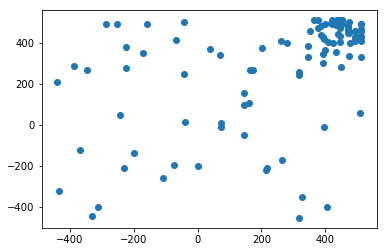

In [8]:
# Scatter Plot of the Final Positions
plt.scatter([list(particles.best_position.values())[ii]['0'] for ii in range(particles.nop)],
            [list(particles.best_position.values())[ii]['1'] for ii in range(particles.nop)])